{'110': 10, '101': 6, '000': 13, '010': 12, '011': 5, '111': 476, '001': 502}


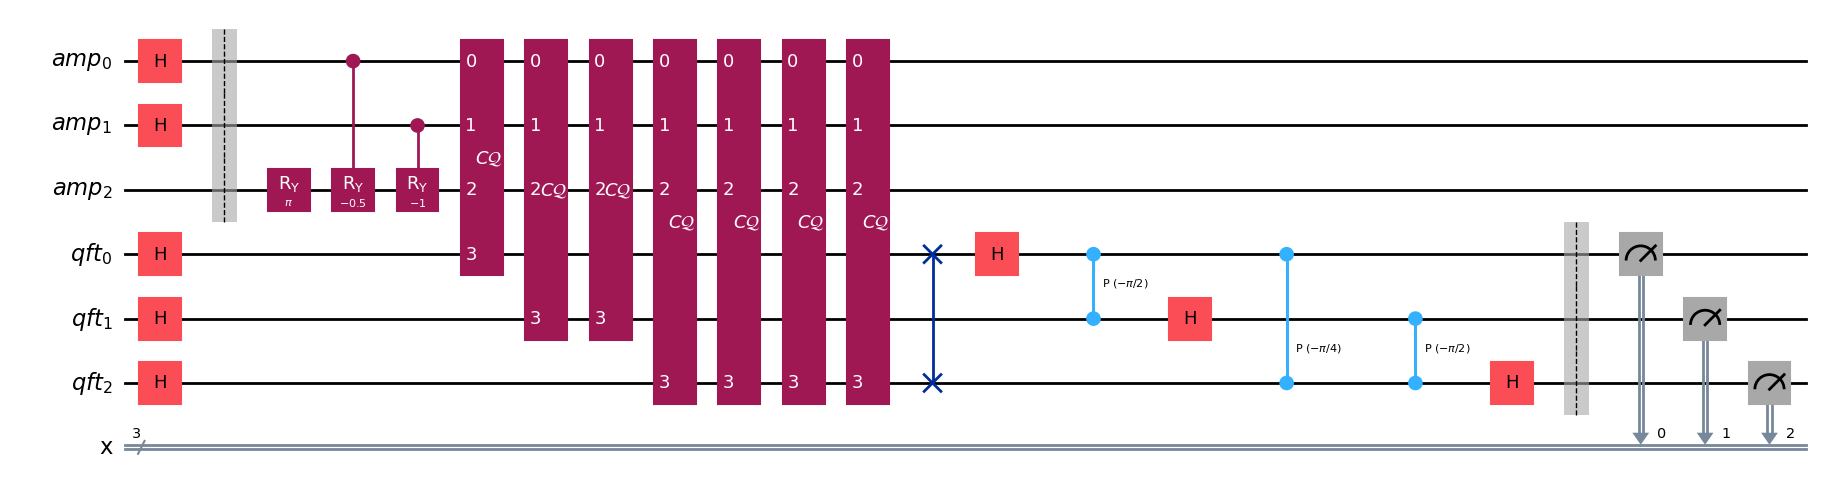

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskitから必要なモジュールをインポート
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit.library import MCXGate  # MCXGateをインポート
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram

qr_amp = QuantumRegister(3, name='amp')
qr_qft = QuantumRegister(3, name='qft')
c = ClassicalRegister(3, name='x')
circuit = QuantumCircuit(qr_amp, qr_qft, c)

def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta / 2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta / 2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

# P
circuit.h([0, 1, 3, 4, 5])

circuit.barrier(qr_amp)

# R
circuit.ry(np.pi, 2)
circuit.cry(-1 / 2, qr_amp[0], qr_amp[2])
circuit.cry(-1, qr_amp[1], qr_amp[2])

# cQ
def cq(circuit, amp, c):
    sub_q = QuantumRegister(4)
    circ = QuantumCircuit(sub_q, name='$C\\mathcal{Q}$')
    circ.cz(3, 2)

    ccry(circ, 1, sub_q[1], 3, sub_q[2])
    ccry(circ, 1 / 2, sub_q[0], 3, sub_q[2])
    circ.cry(-np.pi, 3, sub_q[2])

    circ.ch(3, 1)
    circ.ch(3, 0)

    circ.cx(3, 0)
    circ.cx(3, 1)
    circ.cx(3, 2)

    circ.ch(3, 2)

    # MCXGateを3つの制御ビットと1つのターゲットビットで使用
    mcx = MCXGate(3)  # 3つの制御ビットを指定
    circ.append(mcx, [3, 0, 1, 2])  # 3つの制御ビットと1つのターゲットビット

    circ.ch(3, 2)

    circ.cx(3, 2)
    circ.cx(3, 1)
    circ.cx(3, 0)

    circ.ch(3, 0)
    circ.ch(3, 1)

    circ.cry(np.pi, 3, sub_q[2])
    ccry(circ, -1 / 2, sub_q[0], 3, sub_q[2])
    ccry(circ, -1, sub_q[1], 3, sub_q[2])

    sub_inst = circ.to_instruction()
    circuit.append(sub_inst, [amp[0], amp[1], amp[2], c])

# 振幅増幅
cq(circuit, qr_amp, 3)

for i in range(2):
    cq(circuit, qr_amp, 4)

for i in range(4):
    cq(circuit, qr_amp, 5)

# 逆量子フーリエ変換 (元の回路に戻す)
circuit.swap(3, 5)
circuit.h(3)
circuit.cp(-np.pi / 2, 3, 4)
circuit.h(4)
circuit.cp(-np.pi / 4, 3, 5)
circuit.cp(-np.pi / 2, 4, 5)
circuit.h(5)

circuit.barrier(qr_qft)

circuit.measure(qr_qft, c)

# AerSimulatorを使用したシミュレーション
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=1024).result()

# 結果の取得と表示
answer = result.get_counts(circuit)
print(answer) 
plot_histogram(answer)

# 回路図を描画
circuit.draw(output='mpl', fold=50)


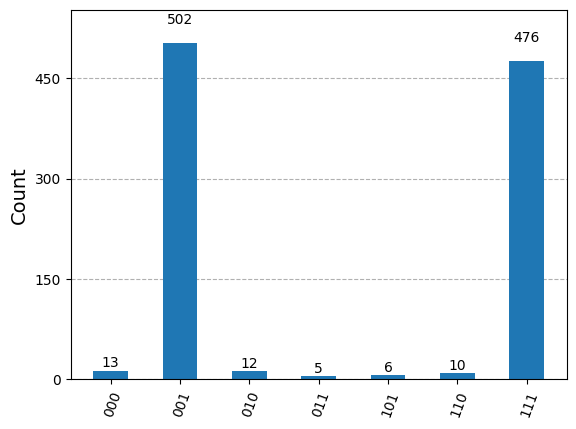

In [9]:
plot_histogram(answer)

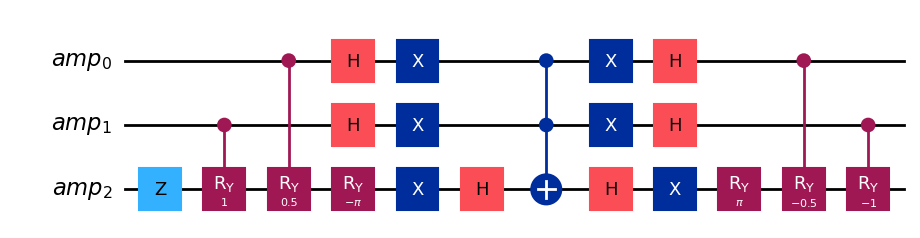

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram
import numpy as np

qr_amp = QuantumRegister(3, name='amp')
circuit = QuantumCircuit(qr_amp)

def ccry(circuit, theta, c1, c2, t):
    sub_q = QuantumRegister(3)
    sub_circ = QuantumCircuit(sub_q, name='$C^2R_Y$\n('+str(theta)[:5]+')')
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(-theta / 2, 2)
    sub_circ.ccx(0, 1, 2)
    sub_circ.ry(theta / 2, 2)
    sub_inst = sub_circ.to_instruction()
    circuit.append(sub_inst, [c1, c2, t])

# 振幅増幅
circuit.z(2)

circuit.cry(1, 1, 2)
circuit.cry(1 / 2, 0, 2)
circuit.ry(-np.pi, 2)
circuit.h([0, 1])

circuit.x([0, 1, 2])
circuit.h(2)
circuit.ccx(0, 1, 2)
circuit.h(2)
circuit.x([2, 1, 0])

circuit.h([0, 1])
circuit.ry(np.pi, 2)
circuit.cry(-1 / 2, 0, 2)
circuit.cry(-1, 1, 2)

# 回路図を描画
circuit.draw(output='mpl', fold=50)
